### Cab-Driver Agent

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
import tensorflow as tf
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
# from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

In [3]:
# Import the environment
from Env import CabDriver
env = CabDriver()

#### Defining Time Matrix

In [4]:
# Loading the time matrix provided
time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [36]:
states_to_track = [
    ((5,11,5),(4,3)),
    ((5,11,5),(2,4)),
    ((3,13,4),(4,3)),
    ((4,18,1),(4,3)),
]

In [6]:
def add_to_dict(state, q_val, action, epi):
    if action not in Q_dict[state]:
        Q_dict[state][action]= []    
    Q_dict[state][action].append((epi, q_val))

In [7]:
def save_tracking_states():
    initialise_tracking_states()

    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action] += [q[1] for q in Q_dict[state][action]]

In [8]:
def initialise_tracking_states():
    sample_q_values = states_to_track    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode   

In [9]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(f'../artifacts/{name}.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [10]:
# Initialise Q_dictionary and States_tracked (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

initialise_tracking_states()

In [11]:
#Defining parameters for the experiment

Episodes = 1000
AN_EPISOD_DAYS = 30                
LR = 0.001                   #learning rate
GAMMA = 0.91
DECAY_RATE = -0.009

threshold = 100            #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
policy_threshold = 400    #every these many episodes,

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [12]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = GAMMA
        self.learning_rate =  LR     
        self.epsilon = 1.0
        self.epsilon_decay = DECAY_RATE
        self.epsilon_min = 0.01
        self.epsilon_max = 1.0
        self.batch_size = 32 
        self.train_start = 100
               
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32,activation='relu',input_dim= self.state_size))
        model.add(Dense(32,activation='relu'))
        model.add(Dense(32,activation='relu'))
        model.add(Dense(self.action_size, activation='relu'))
        
        model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        model.summary
        return model

    def update_target_model(self):
        # update the target Q-value network to current Q-value network after training for a episode. 
        # this means that weights an biases of target Q-value network will become same as current Q-value network.
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state, possible_actions, episode):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay * episode)
        z = np.random.random()
        q_values = self.model.predict(state)
        if z > self.epsilon:
            # model.predict(state)
            # best action - from possible action 
            possible_action_q_values = [q_values[0][index] for index in possible_actions]
            max_q_value = np.max(possible_action_q_values)
            action = list(q_values[0]).index(max_q_value)
        else:
            #randomly select the actions - from possible action  
            action = random.choice(possible_actions)
            # action = q_values[0][random.choice(possible_actions)]
            
        return action, q_values[0][action]
   

    def append_sample(self, state, action, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
        
        # Decay in ε after we generate each sample from the environment
        # if self.epsilon > self.epsilon_min:
        #     self.epsilon *= self.epsilon_decay
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_target = np.zeros((self.batch_size,self.state_size))# write here
            update_input = np.zeros((self.batch_size,self.state_size))# write here
            
            actions, rewards, terminal_states = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done = mini_batch[i]
                
                actions.append(action)
                rewards.append(reward)
                terminal_states.append(done)
                
                #3. Update your 'update_output' and 'update_input' batch
                update_input[i] = state #env.state_encod_arch1(state)
                update_target[i] = next_state #env.state_encod_arch1(next_state)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
            # 2. Get the target for the Q-network
            # target_qval = self.model.predict(update_target)
            target_qval = self.target_model.predict(update_target) 
                
            for i in range(self.batch_size):
                if terminal_states[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)


    # def save(self, name):
    #     self.model.save(name)
    
    def get_model_weights(self):
        return self.model.get_weights()
    
    
    def save(self, name):
        self.model.save_weights(name)

### DQN block

In [13]:
scores, episodes = [], []
mavg_scores = []
state = env.state_init
state_encoded = env.state_encod_arch1(state)
state_size = len(state_encoded)
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)

2022-04-16 15:53:56.211731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 15:53:56.233435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 15:53:56.234111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 15:53:56.235736: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [14]:
# env.requests(state)

In [15]:
start_time = time.time()
start_time

1650104637.0353985

In [16]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    terminal_state = False
    score = 0
    reward = 0
    env.reset()
    state = env.state_init
    time_step = 0

    #Call the DQN agent
    while not terminal_state:
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
        time_step += 1
        
        state_encoded = env.state_encod_arch1(state)
        state_encoded = np.reshape(state_encoded, [1, state_size])
        
        # get possible list of actions from the environment
        possible_actions, action_list = env.requests(state)
        assert possible_actions
        
        action, q_val = agent.get_action(state_encoded, possible_actions, episode)
        
        reward = env.reward_func(state, env.action_space[action], time_matrix)
        next_state, terminal_state = env.next_state_func(state, env.action_space[action], time_matrix)
        
        next_state_encoded = env.state_encod_arch1(next_state)
        next_state_encoded = np.reshape(next_state_encoded, [1, state_size])
        
        agent.append_sample(state_encoded, action, reward, next_state_encoded, terminal_state)
        
        add_to_dict(state, q_val, env.action_space[action], episode)
    
        # agent.train_model()
        if (time_step % 20 == 0) or terminal_state:
            agent.train_model()
        
        score += reward
        
        if terminal_state:
            agent.update_target_model()
            scores.append(score)
            episodes.append(episode)  
            mavg_score = (sum(scores[-100:]) / 100) if (len(scores) >= 100) else (sum(scores) / len(scores))
            mavg_scores.append(mavg_score)
            
    print("Episode:", episode+1, "  score:", score , "  moving avg score:", mavg_score , "  memory length:", len(agent.memory), "  epsilon:", agent.epsilon)

    #TRACKING Q-VALUES
    if ((episode+1) % threshold) == 0:   #every threshold episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')
        # print("Episode:", episode+1, "  score:", score / (episode+1), "  memory length:", len(agent.memory), "  epsilon:", agent.epsilon)

    # plot episode versus score 
    # if episode % threshold == 0: 
    #     pylab.plot(episodes, scores)
    #     pylab.savefig("./" + directory_model + "/cardriver_dqn_" + str(score) + ".png")    
    
    #save the model 
    if episode % policy_threshold == 0:         
        # Model binary h5 file
        agent.save(f"../artifacts/cardriver_dqn_{score}.h5")
        
        # Model pickle file
        save_obj(agent.get_model_weights(), "/cardriver_dqn_" + str(score))
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every policy_threshold episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')  

Episode: 1   score: -514.0   moving avg score: -514.0   memory length: 87   epsilon: 1.0
Episode: 2   score: -100.0   moving avg score: -307.0   memory length: 197   epsilon: 0.9911299749851548
Episode: 3   score: -135.0   moving avg score: -249.66666666666666   memory length: 313   epsilon: 0.9823394220347178
Episode: 4   score: -823.0   moving avg score: -393.0   memory length: 395   epsilon: 0.9736276291090934
Episode: 5   score: -248.0   moving avg score: -364.0   memory length: 485   epsilon: 0.9649938905482919
Episode: 6   score: -49.0   moving avg score: -311.5   memory length: 571   epsilon: 0.9564375070147689
Episode: 7   score: -528.0   moving avg score: -342.42857142857144   memory length: 678   epsilon: 0.9479577854367803
Episode: 8   score: 810.0   moving avg score: -198.375   memory length: 786   epsilon: 0.9395540389522419
Episode: 9   score: -473.0   moving avg score: -228.88888888888889   memory length: 870   epsilon: 0.9312255868530936
Episode: 10   score: 913.0   mov

In [17]:
# %debug

In [18]:
end_time = time.time()
end_time

1650110320.5424135

In [19]:
print(f'Training Time: {(end_time - start_time) / 60} mins')

Training Time: 94.72511691649756 mins


### Tracking Convergence

In [35]:
# Q_dict

In [22]:
# Convergence graphs: Total Q-value per episode
# plt.plot(episodes, scores)
# plt.show()

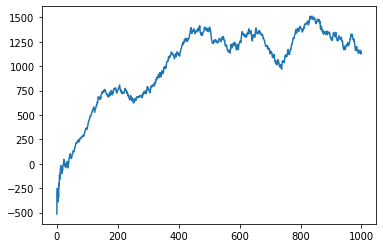

In [23]:
# Convergence graphs: Moving Average rewards per episode
plt.plot(episodes, mavg_scores)
plt.show()

In [42]:
# States_track

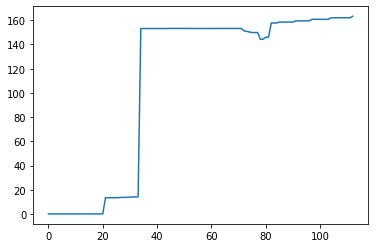

In [38]:
# Convergence graphs: States Tracked
s, a = states_to_track[0]
q_vals = States_track[s][a]
plt.plot(range(len(q_vals)), q_vals)
plt.show()

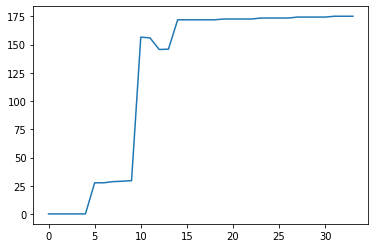

In [39]:
# Convergence graphs: States Tracked
s, a = states_to_track[1]
q_vals = States_track[s][a]
plt.plot(range(len(q_vals)), q_vals)
plt.show()

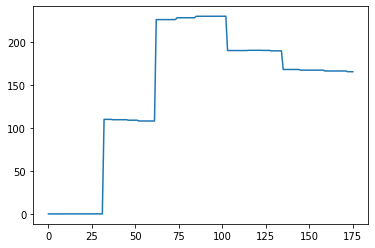

In [40]:
# Convergence graphs: States Tracked
s, a = states_to_track[2]
q_vals = States_track[s][a]
plt.plot(range(len(q_vals)), q_vals)
plt.show()

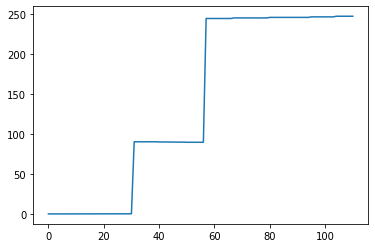

In [41]:
# Convergence graphs: States Tracked
s, a = states_to_track[3]
q_vals = States_track[s][a]
plt.plot(range(len(q_vals)), q_vals)
plt.show()

### Save Final Model

In [44]:
# Model binary h5 file
agent.save(f"../artifacts/cardriver_dqn_final.h5")

# Model pickle file
save_obj(agent.get_model_weights(), "/cardriver_dqn_final")

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [29]:
# time = np.arange(0,1000)
# epsilon = []
# for i in range(0,1000):
#     epsilon.append(0 + (1 - 0) * np.exp(-0.009*i))

In [43]:
# plt.plot(time, epsilon)
# plt.show()